Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/google_drive')

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).


# **Download dataset from Kaggle directly to GC virtual machine**

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# file_path is the path where kaggle.json is present in the Google Drive

In [6]:
%cd /content
#Check the present working directory using pwd command
%pwd
%ls

/content
google_drive/  kaggle.json  sample_data/


In [7]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 98% 1.31G/1.33G [00:19<00:00, 89.0MB/s]
100% 1.33G/1.33G [00:19<00:00, 71.8MB/s]


In [8]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

# **Variational Autoencoder class**

In [2]:
def save_to_disk(txt_path, values):
    if os.path.isfile(txt_path):
        os.remove(txt_path)
    with open(txt_path, "wb") as fp:   
        pickle.dump(values, fp)
    return
def load_from_disk(txt_path):
    with open(txt_path, "rb") as f:
        values =  pickle.load(f)
    return values

TensorFlow 1.x selected.


In [26]:
import numpy as np
import os
import keras
from keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Flatten,Dropout,Dense,Lambda,BatchNormalization,Reshape,Activation
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from keras.utils import plot_model
import keras.backend as K

class VariationalAutoencoder(object):
    def __init__(self,
                 input_dims,
                 latent_space_size,
                 encoder_filters,
                 encoder_kernel_size,
                 encoder_strides,
                 encoder_padding,
                 decoder_filters,
                 decoder_kernel_size,
                 decoder_strides,
                 decoder_padding
                 ):
        self.input_dims = input_dims
        self.latent_space_size = latent_space_size
        self.encoder_filters = encoder_filters
        self.encoder_kernel_size = encoder_kernel_size
        self.encoder_strides = encoder_strides
        self.encoder_padding = encoder_padding
        self.decoder_filters = decoder_filters
        self.decoder_kernel_size = decoder_kernel_size
        self.decoder_strides = decoder_strides
        self.decoder_padding = decoder_padding
        self._create_model()
    def _create_model(self):
        self.images = Input(shape=self.input_dims, name="images")
        # create encoder as separate model      
        encoder_shape_before_flattening = self._create_encoder()
        # create decoder as separate model
        self.decoder_input = Input(shape=(self.latent_space_size,), name="decoder_input")
        self._create_decoder(encoder_shape_before_flattening)
        # create unique model 
        self.model = Model(inputs=self.images, outputs=self.decoder(self.encoder_output))

    def _create_encoder(self):
        # create convolutional layers for encoder
        X = self.images
        for i in range(len(self.encoder_filters)):
            X = self._create_conv_layer(X,
                                        "Conv2D",
                                        self.encoder_filters[i],
                                        self.encoder_kernel_size[i],
                                        self.encoder_strides[i],
                                        self.encoder_padding[i],
                                        "encoder_conv"+str(i)
                                        )
        # keep track of tensor shape before flattening (we will need this to build decoder)
        encoder_shape_before_flattening = K.int_shape(X)[1:]
        # flatten the tensor
        X = Flatten()(X)
        # create dense layers for mu and sigma
        self.encoder_mu = Dense(units=self.latent_space_size, name='encoder_mu')(X)
        self.encoder_log_var = Dense(units=self.latent_space_size, name='encoder_log_var')(X)
        self.encoder_parameters = Model(self.images, (self.encoder_mu, self.encoder_log_var))
        # create encoder output by sampling from normal distribution
        self.encoder_output = Lambda(self.sample_latent_space,name="encoder_output")([self.encoder_mu,self.encoder_log_var])
        self.encoder = Model(inputs=self.images, outputs=self.encoder_output)
        return encoder_shape_before_flattening
    def _create_decoder(self, encoder_shape_before_flattening):
        X = Dense(np.prod(encoder_shape_before_flattening))(self.decoder_input)
        X = Reshape(encoder_shape_before_flattening)(X)
        # create convolutional layers for decoder
        for i in range(len(self.decoder_filters)):
            is_not_last_layer = i < len(self.decoder_filters)-1
            X = self._create_conv_layer(X,
                                        "Conv2DTranspose",
                                        self.decoder_filters[i],
                                        self.decoder_kernel_size[i],
                                        self.decoder_strides[i],
                                        self.decoder_padding[i],
                                        "decoder_conv"+str(i),
                                        batch_norm=is_not_last_layer,
                                        dropout=is_not_last_layer,
                                        activation=is_not_last_layer
                                        )
        # output values should be between 0 and 1
        self.decoder_output = Activation("sigmoid")(X)
        self.decoder = Model(inputs=self.decoder_input, outputs=self.decoder_output)
    def _create_conv_layer(self,input,convolution_type,filters,kernel_size,strides,padding,name,batch_norm=True,dropout=True,activation=True):
        convolution = getattr(keras.layers, convolution_type) # sets Conv2D or Conv2DTranspaose
        conv_layer = convolution(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding = padding,
            name = name
            )
        X = conv_layer(input)
        if batch_norm:
            X = BatchNormalization()(X)
        if activation:
            X = LeakyReLU()(X)
        if dropout:
            X = Dropout(rate=0.25)(X)
        return X
    def sample_latent_space(self, mu_and_log_var):
        mu, log_var = mu_and_log_var
        normal_samples = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * normal_samples
    def compile(self,optimizer, r_loss_factor):
        self.model.compile(optimizer=optimizer, loss=self.penalized_loss(r_loss_factor), metrics=[self.penalized_loss(r_loss_factor)])
    def penalized_loss(self,r_loss_factor):
        def loss(y, y_hat):
            # reconstruction_loss
            r_loss = K.mean(K.square(y-y_hat),axis=[1,2,3]) # dont do mean on batch axis
            # KL loss
            kl_loss = -0.5 * K.sum(1 + self.encoder_log_var - K.square(self.encoder_mu) - K.exp(self.encoder_log_var), axis = 1)    
            return r_loss*r_loss_factor + kl_loss
        return loss
    def train(self,save_path, data_flow, epochs, steps_per_epoch, initial_epoch = 0, lr_decay = 1, learning_rate=0.0005):
        learning_rate_schedule = self.step_decay_schedule(initial_lr=learning_rate, decay_factor=lr_decay, step_size=1)
        history_logger = CSVLogger(os.path.join(save_path, "history.csv"), append=True)
        checkpoint_model = ModelCheckpoint(os.path.join(save_path, "model.h5"), verbose=1)
        checkpoint_weights = ModelCheckpoint(os.path.join(save_path, "weights.h5"), save_weights_only=True, verbose = 1)
        checkpoint_encoder = ModelCheckpoint(os.path.join(save_path, "encoder.h5"), verbose=1)
        checkpoint_encoder.set_model(self.encoder)
        checkpoint_decoder = ModelCheckpoint(os.path.join(save_path, "decoder.h5"), verbose=1)
        checkpoint_decoder.set_model(self.decoder)
        history = self.model.fit_generator(
            data_flow,
            shuffle = True,
            epochs = epochs,
            initial_epoch = initial_epoch,
            steps_per_epoch = steps_per_epoch,
            callbacks = [learning_rate_schedule,
                         history_logger,
                         checkpoint_weights,
                         checkpoint_model,
                         checkpoint_encoder,
                         checkpoint_decoder],
            verbose=1
            )
        return history
    def step_decay_schedule(self,initial_lr, decay_factor, step_size):
        def schedule(epoch):
            return initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return LearningRateScheduler(schedule)
    def load_trained_model(self, load_path, r_loss_factor):
        self.model = load_model(os.path.join(load_path, "model.h5"), custom_objects={"loss": self.penalized_loss(r_loss_factor),"sample_latent_space":self.sample_latent_space})
        #self.encoder = load_model(os.path.join(load_path, "encoder.h5"), custom_objects={"loss": self.penalized_loss(r_loss_factor),"sample_latent_space":self.sample_latent_space})
        #self.decoder = load_model(os.path.join(load_path, "decoder.h5"), custom_objects={"loss": self.penalized_loss(r_loss_factor),"sample_latent_space":self.sample_latent_space})
    def load_trained_weights(self, load_path):
        self.model.load_weights(load_path)
    def plot_model(self,plots_path):
        plots_path = os.path.join(plots_path, "plots")
        os.makedirs(plots_path, exist_ok=True)
        plot_model(self.model, to_file=os.path.join(plots_path,'model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(plots_path,'encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(plots_path,'decoder.png'), show_shapes = True, show_layer_names = True)
        print("Models are ploted in {}".format(plots_path))

# **Create the model**

In [27]:
from keras.optimizers import Adam
OPTIMIZER=Adam(lr=0.0005)
R_LOSS_FACTOR = 10000
INPUT_DIMS = (128,128,3)
EPOCHS = 200
INITIAL_EPOCH = 0
BATCH_SIZE = 32
LATENT_SPACE_SIZE = 200
VAE = VariationalAutoencoder(
    input_dims=INPUT_DIMS,
    latent_space_size=LATENT_SPACE_SIZE,
    encoder_filters=[32,64,64,64],
    encoder_kernel_size=[3,3,3,3],
    encoder_strides=[2,2,2,2],
    encoder_padding = ["same","same","same","same"],
    decoder_filters=[64,64,32,3],
    decoder_kernel_size=[3,3,3,3],
    decoder_strides=[2,2,2,2],
    decoder_padding=["same","same","same","same"]
    )
print("Encoder and decoder model summary:")
VAE.encoder.summary()
VAE.decoder.summary()

VAE.compile(OPTIMIZER, R_LOSS_FACTOR)
VAE.plot_model("google_drive/My Drive/Colab Notebooks")

Encoder and decoder model summary:
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv0 (Conv2D)          (None, 64, 64, 32)   896         images[0][0]                     
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 64, 64, 32)   128         encoder_conv0[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_45 (LeakyReLU)      (None, 64, 64, 32)   0           batch_normalization_45[0][0]     
________________________________________________________

# Continue Training (RUN THIS ONLY IF YOU WANT TO CONTINUE WITH TRAINED WEIGHTS)

In [11]:
VAE.load_trained_model("google_drive/My Drive/Colab Notebooks", R_LOSS_FACTOR)
INITIAL_EPOCH = 0

# **Train**


In [28]:
from keras.preprocessing.image import ImageDataGenerator
# path to the FOLDER contatining images
DATA_PATH = os.path.join(os.getcwd(), "img_align_celeba") 
file_names = []
for file_name in os.listdir(os.path.join(DATA_PATH,"img_align_celeba")):
    file_names.append(file_name)
DATASET_SIZE = len(file_names)
# create image generator and data flow
data_generator = ImageDataGenerator(rescale=1./255)
data_flow = data_generator.flow_from_directory(
    DATA_PATH,
    target_size = INPUT_DIMS[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = "training"
    )
# train the VAE with fit_generator
history = VAE.train(   
    save_path = "google_drive/My Drive/Colab Notebooks",
    data_flow = data_flow,
    epochs = EPOCHS,
    steps_per_epoch = DATASET_SIZE / BATCH_SIZE,
    initial_epoch = INITIAL_EPOCH,
    learning_rate = 0.0005
)
# plot loss 
plt.figure()
plt.plot(history.history['loss'], 'b')
plt.title("Training VAE loss")
plt.show()

Found 202599 images belonging to 1 classes.
Epoch 1/200
6332/6331 [==============================] - 285s 45ms/step - loss: 275.2393 - loss_1: 275.2424

Epoch 00001: saving model to google_drive/My Drive/Colab Notebooks/weights.h5

Epoch 00001: saving model to google_drive/My Drive/Colab Notebooks/model.h5

Epoch 00001: saving model to google_drive/My Drive/Colab Notebooks/encoder.h5

Epoch 00001: saving model to google_drive/My Drive/Colab Notebooks/decoder.h5
Epoch 2/200
2203/6331 [=========>....................] - ETA: 3:04 - loss: 236.1298 - loss_1: 236.1223

KeyboardInterrupt: ignored

# Test 

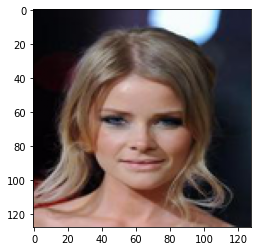

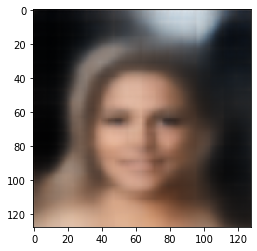

In [20]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

VAE.load_trained_model("google_drive/My Drive/Colab Notebooks",R_LOSS_FACTOR)
example_ind = 10
image_path = os.path.join("img_align_celeba/img_align_celeba",str(example_ind).zfill(6)+".jpg")
pil_image = Image.open(image_path)
pil_image = pil_image.resize((INPUT_DIMS[0],INPUT_DIMS[1]), Image.ANTIALIAS)
image = np.array(pil_image)/255.


latent_space = VAE.encoder.predict(np.expand_dims(image,0))
reconstructed_image = VAE.decoder.predict(latent_space)

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(reconstructed_image.squeeze())